# Import dataset

In [1]:
#pip install keras-tcn --no-dependencies
#pip install tensorflow_addons

In [2]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import pickle
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import keras
import tensorflow as tf
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.initializers import *
from tcn import *

from datetime import datetime

#set folder path
folder = 'data'
#fd = folder + '/uncorrupted_signal_folder'
#fd_km = fd + '/Clusters4096'
fd = folder
fd_km = fd

In [3]:
np.random.seed(1)
tf.random.set_seed(1)

In [4]:
data_train_df = pd.read_pickle(fd_km + '/data_train_v1').reset_index().iloc[:,1:] #full set
data_test_df = pd.read_pickle(fd_km + '/data_test_v1').reset_index().iloc[:,1:]  

# Categorise RUL data

In [5]:
print(data_train_df.RUL.describe())
print(data_test_df.RUL.describe())

count    1.385083e+06
mean     3.477047e+04
std      2.023644e+04
min      0.000000e+00
25%      1.731200e+04
50%      3.462700e+04
75%      5.193900e+04
max      8.189600e+04
Name: RUL, dtype: float64
count     8782.000000
mean     45427.648144
std      15643.733322
min       3964.000000
25%      34177.000000
50%      46891.000000
75%      57867.500000
max      79327.000000
Name: RUL, dtype: float64


[    0.           221.6066482    886.4265928   1994.4598338
  3545.70637119  5540.16620499  7977.83933518 10858.72576177
 14182.82548476 17950.13850416 22160.66481994 26814.40443213
 31911.35734072 37451.52354571 43434.90304709 49861.49584488
 56731.30193906 64044.32132964 71800.55401662 80000.
 81896.        ]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


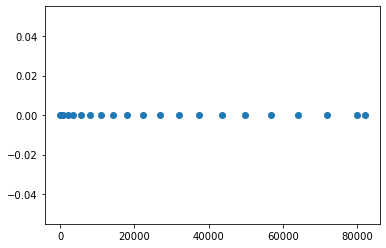

In [6]:
l=0.5
nb_bins = 20 # including one extra bin for RUL>upper_bin_bound
lower_bin_bound = 0
upper_bin_bound = 80000

bins = np.linspace(lower_bin_bound, upper_bin_bound**l, nb_bins)**(1/l)
bins = np.append(bins, data_train_df.RUL.max())

labels=[i for i in range(bins.shape[0]-1)]
plt.plot(bins,np.full(bins.shape[0],0),'o')
print(bins)
print(labels)

In [7]:
data_train_df['RUL_bin'] = pd.cut(data_train_df['RUL'], bins=bins, labels=labels)
data_test_df['RUL_bin'] = pd.cut(data_test_df['RUL'], bins=bins, labels=labels)

In [8]:
data_train_df['RUL_bin'] = pd.cut(data_train_df['RUL'], bins=bins, labels=labels)
data_test_df['RUL_bin'] = pd.cut(data_test_df['RUL'], bins=bins, labels=labels)

In [9]:
display(data_train_df)
display(data_test_df) 

,ID,cycle,gauge1,gauge2,gauge3,RUL,RUL_bin
0,1,0,0.000684,0.000693,0.000695,68053,17
1,1,500,0.000684,0.000693,0.000695,67553,17
2,1,1000,0.000684,0.000693,0.000695,67053,17
3,1,1500,0.000684,0.000693,0.000695,66553,17
4,1,2000,0.000684,0.000693,0.000695,66053,17
...,...,...,...,...,...,...,...
1385078,10000,66500,0.000118,0.000253,0.000761,2393,3
1385079,10000,67000,0.000097,0.000186,0.000755,1893,2
1385080,10000,67500,0.000078,0.000113,0.000743,1393,2
1385081,10000,68000,0.000060,0.000037,0.000718,893,2


,ID,cycle,gauge1,gauge2,gauge3,RUL,RUL_bin
0,1,0,0.000684,0.000693,0.000695,64540,17
1,1,500,0.000684,0.000693,0.000695,64040,16
2,1,1000,0.000684,0.000693,0.000695,63540,16
3,1,1500,0.000684,0.000693,0.000695,63040,16
4,1,2000,0.000684,0.000693,0.000695,62540,16
...,...,...,...,...,...,...,...
8777,100,22000,0.000670,0.000691,0.000696,43346,13
8778,100,22500,0.000670,0.000691,0.000696,42846,13
8779,100,23000,0.000669,0.000691,0.000696,42346,13
8780,100,23500,0.000669,0.000691,0.000696,41846,13


# Build sequences

In [139]:
#utils 
nb_gauges = 3
data_train = data_train_df[data_train_df.ID <= 100]
data_val = data_train_df[data_train_df.ID > 9900]

#prepare forecasting data
def gen_X_sequence(id_df, seq_length, seq_cols, timesteps_pred, type_data = None):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    
    
    ind_start = 0
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0+ind_start, num_elements-seq_length+1-timesteps_pred), range(seq_length+ind_start, num_elements+1-timesteps_pred)):
        yield data_array[start:stop, :]
 

def gen_Y_sequence(id_df, seq_length, seq_cols,timesteps_pred, type_data = None):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    
    
    ind_start = 0
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0+ind_start, num_elements-seq_length+1-timesteps_pred), range(seq_length+ind_start, num_elements+1-timesteps_pred)):
        yield data_array[stop-1, :]#data_array[start+1:stop+1, :]
   



 #prepare data
seq_cols =  ['gauge'+str(i) for i in range(1,4)]#['label'+str(i) for i in range(1,4)]
seq_cols1 =  ['RUL_bin']
sequence_length = 30
timesteps_pred = 1



#training set
seq_gen = (list(gen_X_sequence(data_train[data_train['ID']==id], sequence_length, seq_cols, timesteps_pred, type_data= 'train')) 
                   for id in data_train['ID'].unique())
# generate sequences and convert to numpy array
dbX = np.concatenate(list(seq_gen))



seq_gen = (list(gen_Y_sequence(data_train[data_train['ID']==id], sequence_length, seq_cols1, timesteps_pred, type_data= 'train')) 
                   for id in data_train['ID'].unique())
# generate sequences and convert to numpy array
dbY = np.concatenate(list(seq_gen)).reshape(-1,)

# add one dimension
# dbX = dbX[..., np.newaxis]

print(dbX.shape)
print(dbY.shape)

#test set
seq_gen = (list(gen_X_sequence(data_val[data_val['ID']==id], sequence_length, seq_cols, timesteps_pred, type_data= 'train')) 
                   for id in data_val['ID'].unique())
# generate sequences and convert to numpy array
dbX_val = np.concatenate(list(seq_gen))

seq_gen = (list(gen_Y_sequence(data_val[data_val['ID']==id], sequence_length, seq_cols1, timesteps_pred, type_data= 'train')) 
                   for id in data_val['ID'].unique())
# generate sequences and convert to numpy array
dbY_val = np.concatenate(list(seq_gen)).reshape(-1,)

# add one dimension
# dbX_val = dbX_val[..., np.newaxis]

# dbX_val = (dbX_val + 1)/2
# dbY_val = (dbY_val + 1)/2
print(dbX_val.shape)
print(dbY_val.shape)

(10956, 30, 3)
(10956,)
(10937, 30, 3)
(10937,)


# Build model

In [226]:
input_layer = Input(shape=(dbX.shape[1], dbX.shape[2]))
x = TCN(nb_filters=20, kernel_size=6, nb_stacks=1, dilations=[2 ** i for i in range(6)], padding='causal',
            use_skip_connections=True, dropout_rate=0.0, return_sequences=False,
            activation='relu', kernel_initializer='he_normal', use_batch_norm=False, use_layer_norm=False,
            use_weight_norm=True, name='TCN')(input_layer)
x = Dense(nb_bins)(x)
x = Activation('softmax')(x)
output_layer = x
model = Model(input_layer, output_layer)

In [227]:
opt = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [228]:
model.summary()

Model: "functional_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 30, 3)]           0         
_________________________________________________________________
TCN (TCN)                    (None, 20)                54332     
_________________________________________________________________
dense_28 (Dense)             (None, 20)                420       
_________________________________________________________________
activation_28 (Activation)   (None, 20)                0         
Total params: 54,752
Trainable params: 27,740
Non-trainable params: 27,012
_________________________________________________________________


In [229]:
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d%m%Y%H%M%S")

# save initial weights
model.save_weights('models/PIR_CNN_Model3_4_weights.h5')

model_path = 'models/PIR_CNN_Model3_4.h5'
es = keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0, patience=50, verbose=0, mode='min')
mc = keras.callbacks.ModelCheckpoint(model_path, monitor='accuracy', mode='min', save_best_only=True)

#for batch_size in [32, 64, 128]:
model.load_weights('models/PIR_CNN_Model3_4_weights.h5')
#K.set_value(model.optimizer.learning_rate, l_r)
history = model.fit(dbX, dbY, epochs=50, batch_size=32,
        validation_data=(dbX_val, dbY_val), verbose=2, callbacks = [es,mc])

np.save('models/PIR_CNN_Model3_4_' + timestampStr, history.history)

# get model as json string and save to file
model_as_json = model.to_json()
with open('models/PIR_CNN_Model3_4_' + timestampStr + '.json', "w") as json_file:
    json_file.write(model_as_json)
# save weights to file
model.save_weights('models/PIR_CNN_Model3_4_weights_' + timestampStr + '.h5')

Epoch 1/50
343/343 - 10s - loss: 1.5256 - accuracy: 0.4090 - val_loss: 1.1320 - val_accuracy: 0.4808
Epoch 2/50
343/343 - 8s - loss: 0.9868 - accuracy: 0.5638 - val_loss: 1.1510 - val_accuracy: 0.4831
Epoch 3/50
343/343 - 8s - loss: 0.8744 - accuracy: 0.6124 - val_loss: 1.6720 - val_accuracy: 0.3601
Epoch 4/50
343/343 - 8s - loss: 0.8313 - accuracy: 0.6296 - val_loss: 0.9040 - val_accuracy: 0.5937
Epoch 5/50
343/343 - 8s - loss: 0.8060 - accuracy: 0.6376 - val_loss: 0.8655 - val_accuracy: 0.6157
Epoch 6/50
343/343 - 8s - loss: 0.7853 - accuracy: 0.6548 - val_loss: 0.7961 - val_accuracy: 0.6366
Epoch 7/50
343/343 - 8s - loss: 0.7731 - accuracy: 0.6596 - val_loss: 0.9206 - val_accuracy: 0.5750
Epoch 8/50
343/343 - 8s - loss: 0.7449 - accuracy: 0.6643 - val_loss: 1.2776 - val_accuracy: 0.5008
Epoch 9/50
343/343 - 8s - loss: 0.7265 - accuracy: 0.6775 - val_loss: 1.1101 - val_accuracy: 0.5256
Epoch 10/50
343/343 - 8s - loss: 0.6984 - accuracy: 0.6879 - val_loss: 0.6993 - val_accuracy: 0.680

In [230]:
model.evaluate(dbX_val, dbY_val)

342/342 [==============================] - 2s 6ms/step - loss: 0.5655 - accuracy: 0.7476


[0.5655423402786255, 0.7475541830062866]

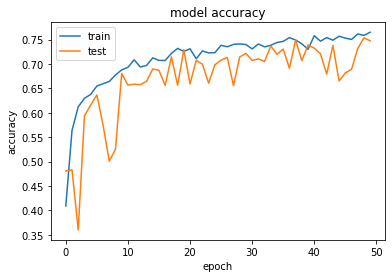

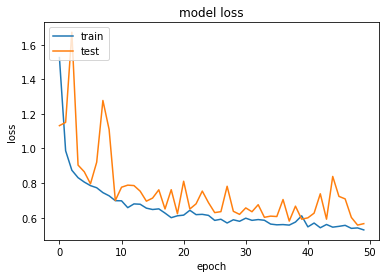

In [231]:
# Load history
#history.history = np.load('models/PIR_CNN_Model3_4_history_03052021151357.npy', allow_pickle=True).item()

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [232]:
print('Minimum val_loss: ' + str(np.min(history.history['val_loss'])))
print('Maximum val_accuracy: ' + str(np.max(history.history['val_accuracy'])))

Minimum val_loss: 0.5572434663772583
Maximum val_accuracy: 0.7536801695823669
